## Terminal category development based on latest PFAS inventory

Prepared by: Grace Patlewicz <br>
Created on: 6th November 2023 <br>
This notebook documents the categorisation process starting with the PFAS landscape comprising all substances meeting the OPPT definition and all TSCA degradation products meeting the same OPPT definition. Analysis here captures the primary-secondary categorisation and subsequent categorisation steps leading to the derivation of terminal categories.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [5]:
df = pd.read_excel(raw_dir+'final_new_inv_df_061123.xlsx', index_col = [0])

Inventory comprises 15,415 substances of which 2959 are degradation products originating from the TSCA inventory substances.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15415 entries, 0 to 3034
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DSSTox_Substance_Id       15415 non-null  object 
 1   DSSTox_QC-Level           12456 non-null  object 
 2   Substance_Name            12456 non-null  object 
 3   Substance_CASRN           12456 non-null  object 
 4   Substance_Type            12456 non-null  object 
 5   Structure_SMILES          15415 non-null  object 
 6   Structure_InChI           12456 non-null  object 
 7   Structure_InChIKey        12456 non-null  object 
 8   Structure_Formula         12456 non-null  object 
 9   Structure_MolWt           12456 non-null  float64
 10  Structure_SMILES_2D-QSAR  8618 non-null   object 
 11  Canonical_QSARr           12203 non-null  object 
 12  TSCA_STATUS               15415 non-null  object 
 13  chain_length              15413 non-null  float64
 14  OECD_Ca

15093 substances with OPERA predictions.

In [9]:
import sys

In [10]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [11]:
from model_functions import *

In [12]:
universe_df = df.copy()

In [36]:
universe_df.rename(columns = {'OECD_Cats': 'category', 'Structure_SMILES': 'smiles', 'DSSTox_Substance_Id': 'dtxsid'}, inplace = True)

In [37]:
universe_df.category.value_counts(dropna = False)

Other aliphatics                 8418
Side-chain aromatics             3794
unclassified                      787
Fluorotelomer PFAA precursors     578
PFAAs                             554
Silicon PFASs                     480
Non-PFAA perfluoroalkyls          272
FASA based PFAA precursors        204
PFAS derivatives                  149
PFAA precursors                   145
Not PFAS                           32
Unable to open ring(s)              2
Name: category, dtype: int64

In [39]:
not_pfas = universe_df[universe_df['category'] == 'Not PFAS']['dtxsid'].tolist()

In [40]:
not_pfas_si = ['DTXSID80631816',
 'DTXSID30787690',
 'DTXSID5059872',
 'DTXSID50448610',
 'DTXSID90962360',
 'MDXUBZVGGFCHAJ-UHFFFAOYSA-N',
 'VSNBTYFDZLAVJV-UHFFFAOYSA-N',
 'YDNBEWGOZYRIPY-UHFFFAOYSA-N']

In [41]:
not_pfas2 = [e for e in not_pfas if e not in not_pfas_si]

In [42]:
universe_df[universe_df['category'] == 'Not PFAS']

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,AD_WS,AD_index_WS,Conf_index_WS,LogHL_pred,HL_predRange,AD_HL,AD_index_HL,Conf_index_HL,ID,tsca_match
1,DTXSID60883371,DSSTox_High,"1,1,2,2-Tetrafluoroethane",359-35-3,Single Compound,FC(F)C(F)F,InChI=1S/C2H2F4/c3-1(4)2(5)6/h1-2H\nAuxInfo=1/...,WXGNWUVNYMJENI-UHFFFAOYSA-N,C2H2F4,102.032,...,1.0,0.676,0.649,-1.30,[-1.48:-1.12],1.0,0.658,0.812,NaN,NaN
9,DTXSID30861929,DSSTox_High,"1-Chloro-1,2,2-trifluoroethane",431-07-2,Single Compound,FC(F)C(F)Cl,InChI=1/C2H2ClF3/c3-1(4)2(5)6/h1-2H\nAuxInfo=1...,FWAQVJAOVDYHAF-UHFFFAOYNA-N,C2H2ClF3,118.480,...,1.0,0.657,0.698,-1.42,[-1.56:-1.28],1.0,0.555,0.782,NaN,NaN
21,DTXSID50620131,Public_Low,"1,1,2,4-Tetrafluorobutane",161791-17-9,Single Compound,FCCC(F)C(F)F,"InChI=1S/C4H6F4/c5-2-1-3(6)4(7)8/h3-4H,1-2H2\n...",NZVWFCYUCPGALF-UHFFFAOYSA-N,C4H6F4,130.086,...,1.0,0.590,0.623,-1.78,[-2.27:-1.29],1.0,0.497,0.649,NaN,NaN
26,DTXSID701019263,Public_Medium,"3-chloro-1,1,2-trifluoropropane",121612-65-5,Mixture of Stereoisomers,FC(F)C(F)CCl,"InChI=1/C3H4ClF3/c4-1-2(5)3(6)7/h2-3H,1H2\nAux...",LPZJIPMNOMNVCV-UHFFFAOYNA-N,C3H4ClF3,132.510,...,1.0,0.675,0.686,-1.48,[-1.74:-1.22],1.0,0.543,0.701,NaN,NaN
38,DTXSID00947103,DSSTox_High,"1,1,2,3,3-Pentafluoropropane",24270-66-4,Single Compound,FC(F)C(F)C(F)F,InChI=1S/C3H3F5/c4-1(2(5)6)3(7)8/h1-3H\nAuxInf...,MWDWMQNTNBHJEI-UHFFFAOYSA-N,C3H3F5,134.049,...,1.0,0.622,0.643,-1.37,[-1.55:-1.19],0.0,0.502,0.739,NaN,NaN
44,DTXSID901023193,DSSTox_Low,3-(Difluoromethyl)-3-fluoropyrrolidine,1566021-07-5,Mixture of Stereoisomers,FC(F)C1(F)CCNC1,"InChI=1/C5H8F3N/c6-4(7)5(8)1-2-9-3-5/h4,9H,1-3...",YYVRBTHOXCPLTR-UHFFFAOYNA-N,C5H8F3N,139.121,...,1.0,0.472,0.599,-6.00,[-7.45:-4.66],1.0,0.457,0.483,NaN,NaN
89,DTXSID50617526,Public_Low,"1,1,2,3-Tetrafluoro-2-(fluoromethyl)propane",65781-27-3,Single Compound,FCC(F)(CF)C(F)F,"InChI=1S/C4H5F5/c5-1-4(9,2-6)3(7)8/h3H,1-2H2\n...",JZIORNIBAKEGFB-UHFFFAOYSA-N,C4H5F5,148.076,...,1.0,0.637,0.737,-1.52,[-2.23:-0.81],1.0,0.445,0.599,NaN,NaN
92,DTXSID50931113,Public_Low,"1,1,2,3,4-Pentafluorobutane",141529-32-0,Single Compound,FCC(F)C(F)C(F)F,"InChI=1/C4H5F5/c5-1-2(6)3(7)4(8)9/h2-4H,1H2\nA...",GHJGWYJLRXSKDU-UHFFFAOYNA-N,C4H5F5,148.076,...,1.0,0.611,0.654,-1.52,[-2.23:-0.81],1.0,0.452,0.601,NaN,NaN
96,DTXSID201036997,DSSTox_Low,"1,1,2,4,4-Pentafluorobutane",119450-77-0,Mixture of Stereoisomers,FC(F)CC(F)C(F)F,"InChI=1/C4H5F5/c5-2(4(8)9)1-3(6)7/h2-4H,1H2\nA...",UXCPFEVTZCJLCW-UHFFFAOYNA-N,C4H5F5,148.076,...,1.0,0.568,0.613,-1.51,[-2.22:-0.8],1.0,0.458,0.603,NaN,NaN
109,DTXSID901019269,Public_Medium,"3-Chloro-1,1,2,3-tetrafluoropropane",149447-91-6,Mixture of Stereoisomers,FC(F)C(F)C(F)Cl,InChI=1/C3H3ClF4/c4-2(6)1(5)3(7)8/h1-3H\nAuxIn...,ORJZANWBXMBMLE-UHFFFAOYNA-N,C3H3ClF4,150.500,...,1.0,0.643,0.627,-1.27,[-1.59:-0.87],1.0,0.520,0.684,NaN,NaN


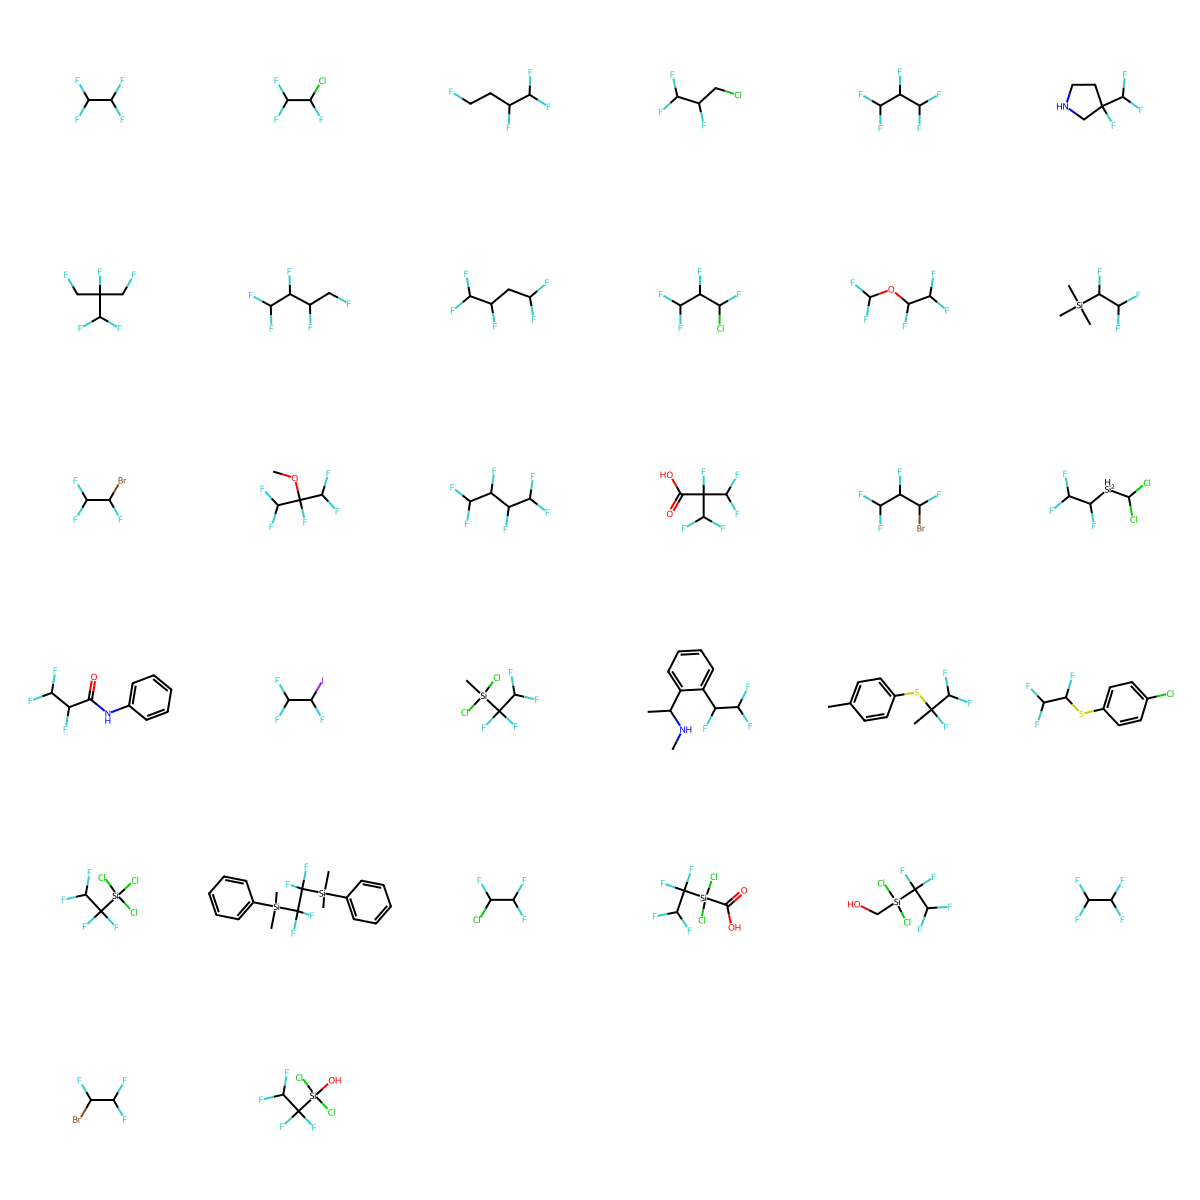

In [24]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in universe_df[universe_df['category'] == 'Not PFAS']['smiles'].tolist()], molsPerRow = 6)

In [49]:
new_index = range(0, len(universe_df))

In [50]:
universe_df = universe_df.set_index(pd.Index(new_index))

In [52]:
for index in universe_df.index:
    if universe_df.loc[index, 'dtxsid' ] in  not_pfas2:
        universe_df.loc[index, 'category'] = 'Other aliphatics'

In [53]:
for index in universe_df.index:
    if universe_df.loc[index, 'dtxsid' ] in  not_pfas_si:
        universe_df.loc[index, 'category'] = 'Silicon PFASs'

In [54]:
universe_df.category.value_counts(dropna = False)

Other aliphatics                 8442
Side-chain aromatics             3794
unclassified                      787
Fluorotelomer PFAA precursors     578
PFAAs                             554
Silicon PFASs                     488
Non-PFAA perfluoroalkyls          272
FASA based PFAA precursors        204
PFAS derivatives                  149
PFAA precursors                   145
Unable to open ring(s)              2
Name: category, dtype: int64

In [55]:
universe_df[universe_df['category'] == 'Unable to open ring(s)']

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,AD_WS,AD_index_WS,Conf_index_WS,LogHL_pred,HL_predRange,AD_HL,AD_index_HL,Conf_index_HL,ID,tsca_match
3170,DTXSID20519826,Public_Low,Bis(pentafluoroethyl)thiadiaziridine,87999-39-1,Single Compound,FC(F)(F)C(F)(F)N1SN1C(F)(F)C(F)(F)F,"InChI=1S/C4F10N2S/c5-1(6,7)3(11,12)15-16(17-15...",IVSMGIULXPTAQV-UHFFFAOYSA-N,C4F10N2S,298.10,...,1.0,0.551,0.456,-3.80,[-5.25:-1.43],0.0,0.338,0.334,NaN,NaN
4903,DTXSID00531243,Public_Low,"4,5-Bis(pentafluoroethyl)-1,2,3,4,5-trithiadia...",87985-86-2,Single Compound,FC(F)(F)C(F)(F)N1SSSN1C(F)(F)C(F)(F)F,"InChI=1S/C4F10N2S3/c5-1(6,7)3(11,12)15-16(18-1...",OTHNRDIUUJSYIT-UHFFFAOYSA-N,C4F10N2S3,362.22,...,1.0,0.505,0.407,-3.28,[-5.25:-0.93],0.0,0.301,0.314,NaN,NaN


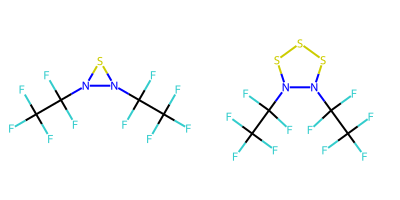

In [57]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in universe_df[universe_df['category'] == 'Unable to open ring(s)']['smiles'].tolist()], molsPerRow = 2)

In [58]:
def subcategory(row):
    if row['chain_length'] >= 7:
        return 'gte7'
    else:
        return 'lt7'

In [59]:
universe_df['subcategory'] = universe_df.apply(lambda row: subcategory(row), axis =1)


In [62]:
universe_df[universe_df['chain_length'].isnull()][['dtxsid', 'smiles','subcategory', 'chain_length']]

,dtxsid,smiles,subcategory,chain_length
4999,DTXSID301146476,CC[N](CC)(CC)(CC(F)(F)C(F)F)OS(=O)(=O)C(F)(F)F,lt7,NaN
12435,DTXSID20153820,OOOOOOOOOOOOOOOC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,lt7,NaN


[10:54:58] Explicit valence for atom # 2 N, 5, is greater than permitted


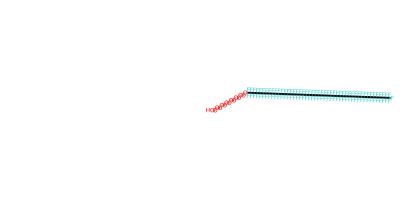

In [63]:
MolsToGridImage([Chem.MolFromSmiles(e) for e in universe_df[universe_df['chain_length'].isnull()]['smiles'].tolist()], molsPerRow = 2)

In [64]:
for index in universe_df.index:
    if universe_df.loc[index, 'dtxsid' ] == 'DTXSID20153820':
        universe_df.loc[index, 'chain_length'] = 47

In [65]:
universe_df['subcategory'] = universe_df.apply(lambda row: subcategory(row), axis =1)

In [66]:
universe_df[universe_df['chain_length'].isnull()][['dtxsid', 'smiles','subcategory', 'chain_length']]

,dtxsid,smiles,subcategory,chain_length
4999,DTXSID301146476,CC[N](CC)(CC)(CC(F)(F)C(F)F)OS(=O)(=O)C(F)(F)F,lt7,NaN


In [67]:
universe_df[universe_df['chain_length']==47][['dtxsid', 'smiles','subcategory', 'chain_length']]

,dtxsid,smiles,subcategory,chain_length
12435,DTXSID20153820,OOOOOOOOOOOOOOOC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,gte7,47.0


Removing substance which can not be resolved by RDKit

In [69]:
universe_df = universe_df[universe_df['dtxsid'] != 'DTXSID301146476']

PFAS Inventory now contains 15,414 substances of which 2959 are degradates arising from TSCA substances and 15,092 could be address by OPERA

In [70]:
universe_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15414 entries, 0 to 15414
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dtxsid                    15414 non-null  object 
 1   DSSTox_QC-Level           12455 non-null  object 
 2   Substance_Name            12455 non-null  object 
 3   Substance_CASRN           12455 non-null  object 
 4   Substance_Type            12455 non-null  object 
 5   smiles                    15414 non-null  object 
 6   Structure_InChI           12455 non-null  object 
 7   Structure_InChIKey        12455 non-null  object 
 8   Structure_Formula         12455 non-null  object 
 9   Structure_MolWt           12455 non-null  float64
 10  Structure_SMILES_2D-QSAR  8617 non-null   object 
 11  Canonical_QSARr           12202 non-null  object 
 12  TSCA_STATUS               15414 non-null  object 
 13  chain_length              15414 non-null  float64
 14  catego

In [71]:
universe_df.category.value_counts(dropna = False)

Other aliphatics                 8442
Side-chain aromatics             3794
unclassified                      786
Fluorotelomer PFAA precursors     578
PFAAs                             554
Silicon PFASs                     488
Non-PFAA perfluoroalkyls          272
FASA based PFAA precursors        204
PFAS derivatives                  149
PFAA precursors                   145
Unable to open ring(s)              2
Name: category, dtype: int64

In [72]:
universe_df.groupby(['category', 'subcategory']).size().sort_values(ascending = False)

category                       subcategory
Other aliphatics               lt7            6352
Side-chain aromatics           lt7            3222
Other aliphatics               gte7           2090
Side-chain aromatics           gte7            572
unclassified                   lt7             466
PFAAs                          lt7             378
Silicon PFASs                  lt7             377
unclassified                   gte7            320
Fluorotelomer PFAA precursors  gte7            312
                               lt7             266
Non-PFAA perfluoroalkyls       lt7             223
PFAAs                          gte7            176
PFAS derivatives               lt7             149
Silicon PFASs                  gte7            111
FASA based PFAA precursors     gte7            106
                               lt7              98
PFAA precursors                lt7              88
                               gte7             57
Non-PFAA perfluoroalkyls       gte7    

In [73]:
new = universe_df.groupby(['category', 'subcategory']).size().reset_index()
new['percentage'] = new[0].apply(lambda x: x/universe_df.shape[0])
new

,category,subcategory,0,percentage
0,FASA based PFAA precursors,gte7,106,0.006877
1,FASA based PFAA precursors,lt7,98,0.006358
2,Fluorotelomer PFAA precursors,gte7,312,0.020241
3,Fluorotelomer PFAA precursors,lt7,266,0.017257
4,Non-PFAA perfluoroalkyls,gte7,49,0.003179
5,Non-PFAA perfluoroalkyls,lt7,223,0.014467
6,Other aliphatics,gte7,2090,0.135591
7,Other aliphatics,lt7,6352,0.412093
8,PFAA precursors,gte7,57,0.003698
9,PFAA precursors,lt7,88,0.005709


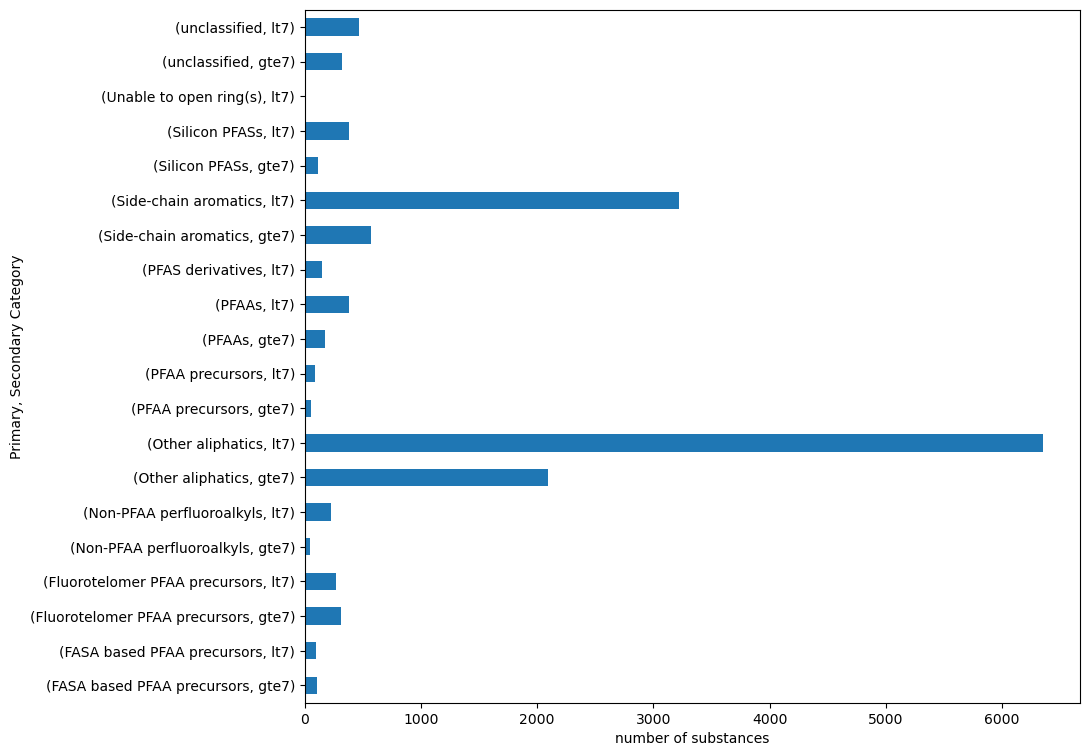

In [75]:
plt.figure(figsize = (10,9))
universe_df.groupby(['category', 'subcategory']).size().plot.barh()
plt.ylabel('Primary, Secondary Category')
plt.xlabel('number of substances')
plt.savefig(figures_dir+'Figure1_061123.png', dpi = 300, bbox_inches='tight');


In [77]:
universe_df[universe_df['smiles'].isnull()]

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,AD_index_WS,Conf_index_WS,LogHL_pred,HL_predRange,AD_HL,AD_index_HL,Conf_index_HL,ID,tsca_match,subcategory


In [78]:
results = {}
for i, group in universe_df.groupby(['category', 'subcategory']):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results[i] = a


[11:42:21] WARNING: not removing hydrogen atom without neighbors


In [79]:
len(list(results.keys()))

20

In [80]:
distances = {}
for k,v in results.items():
    a = distance_matrix(results[k])
    distances[k] = a

In [81]:
universe_df['cluster'] = universe_df[['category', 'subcategory']].apply(tuple, axis = 1)

In [82]:
centres = []
for i,group in universe_df.groupby(['category', 'subcategory']):
    try:
        m = medoid_calc(distances[i])
        centres.append(m)
    except Exception as error:
        print(error)

In [83]:
len(centres)

20

In [84]:
universe_df['cluster_centroid'] = universe_df['dtxsid'].apply(lambda x: 'centroid' if x in (centres) else np.nan)

In [85]:
df2 = universe_df.set_index('dtxsid')

Create dictionary of the distances so we can compute the pairwise distance from the given centroid of each category-subcategory combination

In [86]:
members = {}

for i, group in df2.groupby(['category', 'subcategory']):
    subset = group[['cluster', 'cluster_centroid']]
    #print(subset)
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances[i][x].index, distances[i][x].values]
                members[x] = c
    except Exception as error:
            print(error)


In [87]:
cluster_members = pd.DataFrame(list(members.items()))

In [88]:
cluster_members.columns = ['centroid', 1]
cluster_members[['analogues','Dist']] = pd.DataFrame(cluster_members[1].tolist(), index= cluster_members.index)
cluster_members.drop([1], axis = 1, inplace = True)
cluster_members2 = cluster_members.apply(pd.Series.explode)

In [89]:
cluster_members2.head(10)

,centroid,analogues,Dist
0,DTXSID6071908,DTXSID8071358,0.64
0,DTXSID6071908,DTXSID1071907,0.615385
0,DTXSID6071908,DTXSID001026645,0.660714
0,DTXSID6071908,DTXSID301026644,0.592593
0,DTXSID6071908,DTXSID6071665,0.509804
0,DTXSID6071908,DTXSID1067629,0.64
0,DTXSID6071908,DTXSID801033084,0.408163
0,DTXSID6071908,DTXSID1071662,0.375
0,DTXSID6071908,DTXSID1032646,0.615385
0,DTXSID6071908,DTXSID6071908,0.0


In [90]:
cluster_members2.centroid.nunique()

20

In [91]:
df_1 = universe_df.sort_values(by = ['category', 'subcategory', 'cluster', 'cluster_centroid'], ascending = [True, True,True, False])
df_1['centroid'] = df_1.apply(lambda x: x['dtxsid'] if x['cluster_centroid'] == 'centroid' else np.nan, axis = 1)

In [92]:
df_1['centroid2'] = df_1['centroid'].fillna(method = 'ffill')

In [93]:
mydict = {}
for i, group in df_1.groupby('centroid2'):
    k = [n for n in group['centroid2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict[k] = v

In [94]:
dist = []
for i, group in cluster_members2.groupby('centroid'):
    a = cluster_members2[(cluster_members2['centroid'] == i) & (cluster_members2['analogues'].isin(mydict[i]))]
    dist.append(a)

In [95]:
dist_df = pd.concat([e for e in dist])

In [96]:
final_df = pd.merge(df_1, dist_df, left_on = 'dtxsid', right_on = 'analogues', how = 'left')

In [97]:
final_df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,ID,tsca_match,subcategory,cluster,cluster_centroid,centroid_x,centroid2,centroid_y,analogues,Dist
0,DTXSID6071908,DSSTox_High,N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...,68957-63-1,Single Compound,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,"InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...",IOQHTIQMCISFKB-UHFFFAOYSA-N,C11H8F15NO4S,535.22,...,NaN,NaN,gte7,"(FASA based PFAA precursors, gte7)",centroid,DTXSID6071908,DTXSID6071908,DTXSID6071908,DTXSID6071908,0.0
1,DTXSID8071358,DSSTox_High,N-Methyl-perfluoro-1-heptanesulfonamide,68259-14-3,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...",KDHCALLFPWZTPN-UHFFFAOYSA-N,C8H4F15NO2S,463.16,...,NaN,NaN,gte7,"(FASA based PFAA precursors, gte7)",NaN,NaN,DTXSID6071908,DTXSID6071908,DTXSID8071358,0.64
2,DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,...,NaN,NaN,gte7,"(FASA based PFAA precursors, gte7)",NaN,NaN,DTXSID6071908,DTXSID6071908,DTXSID1071907,0.615385
3,DTXSID001026645,DSSTox_Low,"1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...",167398-54-1,Single Compound,OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,"InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...",LJJUSVBJKZXMCP-UHFFFAOYSA-N,C9H6F15NO3S,493.19,...,NaN,NaN,gte7,"(FASA based PFAA precursors, gte7)",NaN,NaN,DTXSID6071908,DTXSID6071908,DTXSID001026645,0.660714
4,DTXSID301026644,DSSTox_Low,(Perfluoroheptyl)(sulfonylamino)acetic acid,1003194-00-0,Single Compound,OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...",LAAXCIZXZCKWFF-UHFFFAOYSA-N,C9H4F15NO4S,507.17,...,NaN,NaN,gte7,"(FASA based PFAA precursors, gte7)",NaN,NaN,DTXSID6071908,DTXSID6071908,DTXSID301026644,0.592593


In [99]:
writer = pd.ExcelWriter(interim_dir+'secondary_categorisations_new_universe_061123.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_df.to_excel(writer)

writer.close()


Deriving an objective threshold to decide when a category-subcategory needs to be clustered to its next generation of subclusters

In [100]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import inconsistent

In [101]:
from itertools import permutations, combinations

In [102]:
perm = combinations(list(distances.keys()), 2)

In [103]:
perm_combs = []
for i in list(perm):
    perm_combs.append(i)

In [104]:
perm_combs = list(set(perm_combs))

In [105]:
len(perm_combs)

190

In [106]:
perm_combs2 = [(a,b) for a, b in perm_combs if a[0] != b[0]]
len(perm_combs2)

181

In [107]:
results_dict = {}
for i in perm_combs2:
    x, y = i
    a = pd.concat([results[x], results[y]])
    results_dict[i] = a

In [108]:
distance_dict = {}
for k, v in results_dict.items():
    distance_dict[k] = pd.DataFrame(squareform(pdist(results_dict[k], 'Jaccard')), columns = results_dict[k].index, index =results_dict[k].index)

In [ ]:
df_dict = {}
for k,v in distance_dict.items():
    x, y = k
    df = distance_dict[k]
    for i in df.index:
        for c in df.columns:
            if i in results[x].index and c in results[x].index:
                df.loc[i,c] = np.nan
            if i in results[y].index and c in results[y].index:
                df.loc[i,c] = np.nan
    df_dict[k] = df


In [ ]:
summaries_bt = []
for k,v in df_dict.items():
      summaries_bt.append(plug_in_stack(df_dict[k], label = k))


In [ ]:
len(summaries_bt)

In [ ]:
len(df_dict)

In [ ]:
summaries = []
for k,v in distances.items():
    if len(v)  >1:
        summaries.append(plug_in(distances[k], label = k))

In [ ]:
import pickle
pickle.dump( summaries, open(interim_dir+ "within_cat_chl7_061123.pkl", "wb" ) )
pickle.dump( summaries_bt, open(interim_dir+ "between_cat_chl7_061123.pkl", "wb" ) )


In [ ]:
fig, ax = plt.subplots(figsize = (10,9))
for i in range(len(summaries)):
    ax.set_xlabel('Distance')
    ax.set_ylabel('ECDF')
    #ax.set_title('ECDFs of within Category-Subcategory combinations')
    ax.plot(summaries[i]['ecdfx'],summaries[i]['ecdfy'], marker = '.', linestyle = 'none', label = summaries[i]['label'])
    ax.legend(bbox_to_anchor=(1, 1))
    #ax.annotate(" ", xy = (0.65,0.8), xytext = (0.5, 0.8), arrowprops = dict(arrowstyle = '->', lw = 2, color = 'black'))
    #ax.annotate(" ", xy = (1,0.2), xytext = (0.85, 0.2), arrowprops = dict(arrowstyle = '<-', lw = 2, color = 'black'))
fig.savefig(figures_dir+'FigureS1_061123.png', dpi = 300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize = (10,9))
for i in range(len(summaries_bt))[0:10]:
    ax.set_xlabel('Distance')
    ax.set_ylabel('ECDF')
    #ax.set_title('ECDFs of selected between Category-Subcategory combinations')
    ax.plot(summaries_bt[i]['ecdfx'],summaries_bt[i]['ecdfy'], marker = '.', linestyle = 'none', label = summaries_bt[i]['label']);
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlim([0,1])
fig.savefig(figures_dir+'FigureS2_061123.png', dpi = 300, bbox_inches='tight')

In [ ]:
dist_thresholds = []
for i in range(0, len(summaries)):
    a, b  = summaries[i]['label'], summaries[i]['50PCTILE']
    dist_thresholds.append([a,b])


dist_thresholds = pd.DataFrame(dist_thresholds, columns = ['label', '50PCTILE'])

dist_thresholds.plot(kind = 'hist', bins = 10);


In [ ]:
distb_thresholds = []
for i in range(0, len(summaries_bt)):
    a, b  = summaries_bt[i]['label'], summaries_bt[i]['50PCTILE']
    distb_thresholds.append([a,b])


distb_thresholds = pd.DataFrame(distb_thresholds, columns = ['label', '50PCTILE'])

distb_thresholds.plot(kind = 'hist', bins = 10);

In [ ]:
defined_threshold = round(np.percentile(distb_thresholds['50PCTILE'],5),2)

In [ ]:
defined_threshold

In [ ]:
_thresholds = []
for i in range(0, len(summaries)):
    a, b  = summaries[i]['label'], summaries[i]['50PCTILE']
    _thresholds.append([a,b])


_thresholds = pd.DataFrame(_thresholds, columns = ['label', '50PCTILE'])

In [ ]:
above_threshold = _thresholds[_thresholds['50PCTILE'] >=defined_threshold]['label'].to_list()

In [ ]:
len(above_threshold)

In [ ]:
_thresholds[_thresholds['50PCTILE'] >=defined_threshold]

In [ ]:
_thresholds[_thresholds['50PCTILE'] >=defined_threshold].shape

In [ ]:
fig, ax = plt.subplots(figsize = (10,9))
sns.distplot(distb_thresholds['50PCTILE'], kde = True, label = 'between')
sns.distplot(dist_thresholds['50PCTILE'], kde = True, label = 'within')
#ax.set_title('Distributions of within and between cat-subcat distances')
#ax.text(0.78, 5, defined_threshold)
ax.annotate('threshold (0.75)', xy = (0.75,5), xytext = (0.75,7), horizontalalignment = 'center', arrowprops = dict(arrowstyle = '->', lw = 1))
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xlabel('median values of the Jaccard pairwise distance distributions')
fig.savefig(figures_dir+'Figure2_061123.png', dpi = 300, bbox_inches='tight')